In [111]:
import matplotlib.image as mpimg
import numpy as np
import cv2
import os
import glob
import matplotlib.pyplot as plt
import time
from skimage.feature import hog
from sklearn.svm import LinearSVC,SVC
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split,cross_val_score
from scipy.ndimage.measurements import label
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.metrics import precision_score, recall_score, accuracy_score
from sklearn.ensemble import RandomForestClassifier,GradientBoostingClassifier, AdaBoostClassifier
%matplotlib inline

### 1. Data Exploration


In [89]:
# Define a function to return some characteristics of the dataset 
def data_look(car_list, notcar_list):
    data_dict = {}
    # Define a key in data_dict "n_cars" and store the number of car images
    data_dict["n_cars"] =len(car_list)
    # Define a key "n_notcars" and store the number of notcar images
    data_dict["n_notcars"] = len(notcar_list)
    example_img = mpimg.imread(car_list[0])
    example_img2 = mpimg.imread(notcar_list[0])

    # Read in a test image, either car or notcar
    # Define a key "image_shape" and store the test image shape 3-tuple
    data_dict["car_shape"] = example_img.shape
    data_dict["notcar_shape"] = example_img2.shape

    # Define a key "data_type" and store the data type of the test image.
    data_dict["data_type"] = example_img.dtype
    # Return data_dict
    return data_dict

Your function returned a count of 8792  cars and 8968  non-cars
of size:  (64, 64, 3)  (car) (64, 64, 3) (not car) and data type: float32
car image:vehicles/KITTI_extracted/1569.png, not car image:non-vehicles/GTI/image3001.png


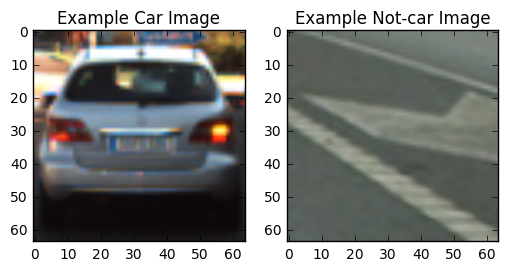

In [90]:
cars = glob.glob('vehicles/**/*.png', recursive=True)
notcars = glob.glob('non-vehicles/**/*.png', recursive=True)

np.random.shuffle(cars)
np.random.shuffle(notcars)

data_info = data_look(cars, notcars)

print('Your function returned a count of', data_info["n_cars"], ' cars and', data_info["n_notcars"], ' non-cars')
print('of size: ',data_info["car_shape"],' (car)', data_info["notcar_shape"],'(not car) and data type:', data_info["data_type"])
# Just for fun choose random car / not-car indices and plot example images   
car_ind = np.random.randint(0, len(cars))
notcar_ind = np.random.randint(0, len(notcars))
    
# Read in car / not-car images
car_image = mpimg.imread(cars[car_ind])
notcar_image = mpimg.imread(notcars[notcar_ind])
print("car image:{}, not car image:{}".format(cars[car_ind],notcars[notcar_ind]))


# Plot the examples
fig = plt.figure()
plt.subplot(121)
plt.imshow(car_image)
plt.title('Example Car Image')
plt.subplot(122)
plt.imshow(notcar_image)
plt.title('Example Not-car Image')

In [91]:
# Define a function to return HOG features and visualization
def get_hog_features(img, orient, pix_per_cell, cell_per_block, 
                        vis=False, feature_vec=True):
    # Call with two outputs if vis==True
    if vis == True:
        features, hog_image = hog(img, orientations=orient, 
                                  pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), 
                                  transform_sqrt=True, 
                                  visualise=vis, feature_vector=feature_vec)
        return features, hog_image
    # Otherwise call with one output
    else:      
        features = hog(img, orientations=orient, 
                       pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), 
                       transform_sqrt=True, 
                       visualise=vis, feature_vector=feature_vec)
        return features

# Define a function to compute binned color features  
def bin_spatial(img, size=(32, 32)):
    # Use cv2.resize().ravel() to create the feature vector
    features = cv2.resize(img, size).ravel() 
    # Return the feature vector
    return features

# Define a function to compute color histogram features 
# NEED TO CHANGE bins_range if reading .png files with mpimg!
def color_hist(img, nbins=32, bins_range=(0, 256)):
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins, range=bins_range)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins, range=bins_range)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins, range=bins_range)
       # Generating bin centers
    bin_edges = channel1_hist[1]
    bin_centers = (bin_edges[1:]  + bin_edges[0:len(bin_edges)-1])/2
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return channel1_hist, channel2_hist, channel3_hist, bin_centers, hist_features

# Define a function to extract features from a list of images
# Have this function call bin_spatial() and color_hist()
def extract_features(imgs, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for file in imgs:
        file_features = []
        # Read in each one by one
        image = mpimg.imread(file)
        image = np.uint8(image * 255)           # Scale training images in PNG from 0-1 to 0-255

        # apply color conversion if other than 'RGB'
        if color_space != 'RGB':
            if color_space == 'HSV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
            elif color_space == 'LUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
            elif color_space == 'HLS':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
            elif color_space == 'YUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
            elif color_space == 'YCrCb':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
        else: feature_image = np.copy(image)      

        if spatial_feat == True:
            spatial_features = bin_spatial(feature_image, size=spatial_size)
            file_features.append(spatial_features)
        if hist_feat == True:
            # Apply color_hist()
            hist_features = color_hist(feature_image, nbins=hist_bins)
            file_features.append(hist_features[4])
        if hog_feat == True:
        # Call get_hog_features() with vis=False, feature_vec=True
            if hog_channel == 'ALL':
                hog_features = []
                for channel in range(feature_image.shape[2]):
                    hog_features.append(get_hog_features(feature_image[:,:,channel], 
                                        orient, pix_per_cell, cell_per_block, 
                                        vis=False, feature_vec=True))
                hog_features = np.ravel(hog_features)        
            else:
                hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                            pix_per_cell, cell_per_block, vis=False, feature_vec=True)
            # Append the new feature vector to the features list
            file_features.append(hog_features)
        features.append(np.concatenate(file_features))
    # Return list of feature vectors
    return features
    
# Define a function that takes an image,
# start and stop positions in both x and y, 
# window size (x and y dimensions),  
# and overlap fraction (for both x and y)
def slide_window(img, x_start_stop=[None, None], y_start_stop=[None, None], 
                    xy_window=(64, 64), xy_overlap=(0.5, 0.5)):
    # If x and/or y start/stop positions not defined, set to image size
    if x_start_stop[0] == None:
        x_start_stop[0] = 0
    if x_start_stop[1] == None:
        x_start_stop[1] = img.shape[1]
    if y_start_stop[0] == None:
        y_start_stop[0] = 0
    if y_start_stop[1] == None:
        y_start_stop[1] = img.shape[0]
    # Compute the span of the region to be searched    
    xspan = x_start_stop[1] - x_start_stop[0]
    yspan = y_start_stop[1] - y_start_stop[0]
    # Compute the number of pixels per step in x/y
    nx_pix_per_step = np.int(xy_window[0]*(1 - xy_overlap[0]))
    ny_pix_per_step = np.int(xy_window[1]*(1 - xy_overlap[1]))
    # Compute the number of windows in x/y
    nx_windows = np.int(xspan/nx_pix_per_step) - 1
    ny_windows = np.int(yspan/ny_pix_per_step) - 1
    # Initialize a list to append window positions to
    window_list = []
    # Loop through finding x and y window positions
    # Note: you could vectorize this step, but in practice
    # you'll be considering windows one by one with your
    # classifier, so looping makes sense
    for ys in range(ny_windows):
        for xs in range(nx_windows):
            # Calculate window position
            startx = xs*nx_pix_per_step + x_start_stop[0]
            endx = startx + xy_window[0]
            starty = ys*ny_pix_per_step + y_start_stop[0]
            endy = starty + xy_window[1]
            
            # Append window position to list
            window_list.append(((startx, starty), (endx, endy)))
    # Return the list of windows
    return window_list

# Define a function to draw bounding boxes
def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    # Make a copy of the image
    imcopy = np.copy(img)
    # Iterate through the bounding boxes
    for bbox in bboxes:
        # Draw a rectangle given bbox coordinates
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
    # Return the image copy with boxes drawn
    return imcopy


### 2.Feature Extraction

(96,)


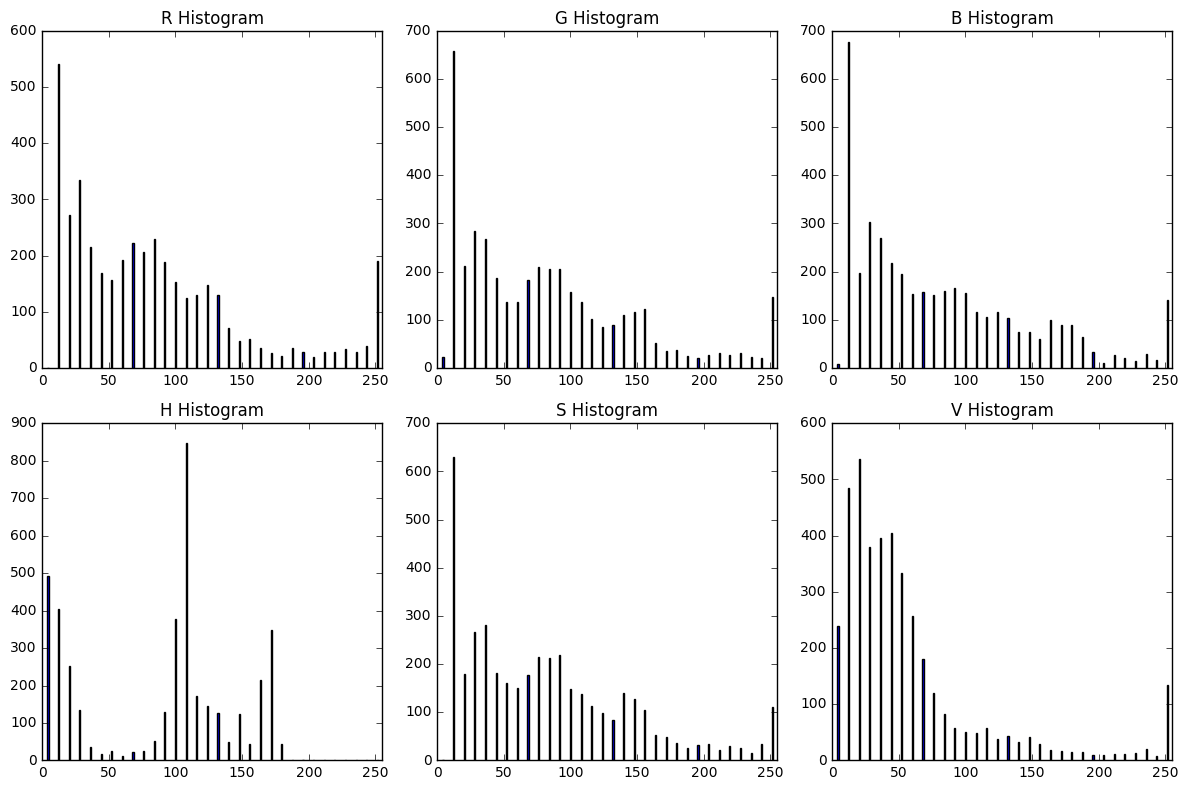

In [92]:
rh, gh, bh, bincen, feature_vec = color_hist(np.uint8(car_image * 255) , nbins=32, bins_range=(0, 255))

hh, sh, vh, bincen2, feature_vec2 = color_hist(cv2.cvtColor(np.uint8(car_image * 255), cv2.COLOR_RGB2HLS).astype(np.float) , nbins=32, bins_range=(0, 255))

print(feature_vec.shape)
# Plot a figure with all three bar charts
if rh is not None:
    fig = plt.figure(figsize=(12,8))
    plt.subplot(231)
    plt.bar(bincen, rh[0])
    plt.xlim(0, 255)
    plt.title('R Histogram')
    plt.subplot(232)
    plt.bar(bincen, gh[0])
    plt.xlim(0, 255)
    plt.title('G Histogram')
    plt.subplot(233)
    plt.bar(bincen, bh[0])
    plt.xlim(0, 255)
    plt.title('B Histogram')
    plt.subplot(234)
    plt.bar(bincen2, hh[0])
    plt.xlim(0, 255)
    plt.title('H Histogram')
    plt.subplot(235)
    plt.bar(bincen2, sh[0])
    plt.xlim(0, 255)
    plt.title('S Histogram')
    plt.subplot(236)
    plt.bar(bincen2, vh[0])
    plt.xlim(0, 255)
    plt.title('V Histogram')
    fig.tight_layout()
    plt.savefig("output_images/color_hist.jpg")
else:
    print('Your function is returning None for at least one variable...')

(1764,)


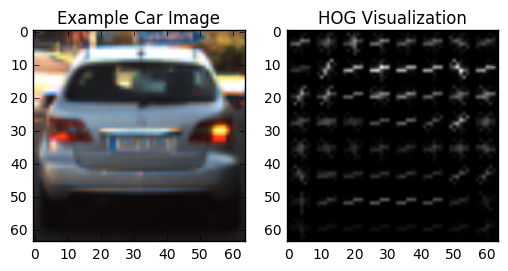

In [93]:
gray = cv2.cvtColor(car_image, cv2.COLOR_RGB2GRAY)
# Define HOG parameters
orient = 9
pix_per_cell = 8
cell_per_block = 2
# Call our function with vis=True to see an image output
features, hog_image = get_hog_features(gray, orient, 
                        pix_per_cell, cell_per_block, 
                        vis=True, feature_vec=False)


# Plot the examples
fig = plt.figure()
plt.subplot(121)
plt.imshow(car_image, cmap='gray')
plt.title('Example Car Image')
plt.subplot(122)
plt.imshow(hog_image, cmap='gray')
plt.title('HOG Visualization')
plt.savefig("output_images/hog.jpg")

print(features.flatten().shape)


(3072,)


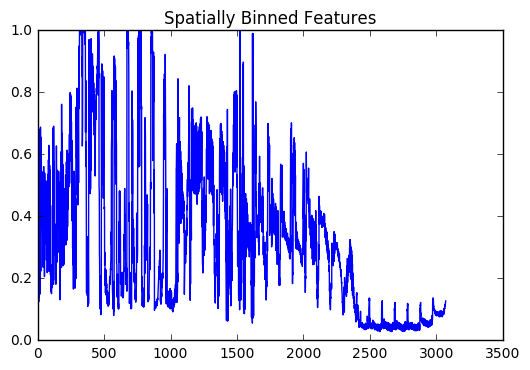

In [94]:
feature_vec = bin_spatial(car_image, size=(32, 32))
print(feature_vec.shape)

# Plot features
plt.plot(feature_vec)
plt.title('Spatially Binned Features')
plt.savefig("output_images/spatial_bin.jpg")


#### global variable, parameter tunning

In [95]:
color_space = 'YCrCb' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 9  # HOG orientations
pix_per_cell = 8 # HOG pixels per cell
cell_per_block = 2 # HOG cells per block
hog_channel = 0 # Can be 0, 1, 2, or "ALL"
spatial_size = (16, 16) # Spatial binning dimensions
hist_bins = 32    # Number of histogram bins

In [96]:
print("Loading images and extracting features...")
t = time.time()
vehicle_features = extract_features(cars, color_space=color_space, spatial_size=spatial_size,hist_bins=hist_bins, orient=orient, 
                    pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, hog_channel=hog_channel,spatial_feat=True, hist_feat=True, hog_feat=True)
non_vehicle_features = extract_features(notcars, color_space=color_space, spatial_size=spatial_size,hist_bins=hist_bins, orient=orient, 
                    pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, hog_channel=hog_channel,spatial_feat=True, hist_feat=True, hog_feat=True)


# Create an array stack of all feature vectors and scale the resulting feature vector
X = np.vstack((np.array(vehicle_features), np.array(non_vehicle_features))).astype(np.float64)
X_scaler = StandardScaler().fit(X)
scaled_X = X_scaler.transform(X)

# Define the labels vector (1 = vehicle, 0 = non-vehicle)
y = np.hstack((np.ones(len(vehicle_features)), np.zeros(len(non_vehicle_features))))
t2 = time.time()

print('Number of features: {}'.format(scaled_X.shape[1]))
print('Feature extraction time: {}s'.format(round(t2 - t, 2)))


Loading images and extracting features...
Number of features: 2628
Feature extraction time: 61.35s


### 3. Build Classifier

In [97]:
# Split the training set into randomized training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,random_state=46, stratify=y)



In [106]:
X_train.shape


(14208, 2628)

In [107]:
def model_train(X_train, y_train, X_test, y_test ,classifer=LinearSVC()):
    clf = classifer
    t = time.time()
    clf.fit(X_train, y_train)
    t2 = time.time()
    print('Classifier training time: {}'.format(round(t2 - t, 2)))
    print('Classifier training set accuracy: {}'.format(round(clf.score(X_train, y_train), 4)))
    print('Classifier test set accuracy: {}'.format(round(clf.score(X_test, y_test), 4)))

    return clf



In [102]:
# clf = RandomForestClassifier(n_estimators = 100,random_state = 42,) 

# # Tuning Classifier Parameters

# # max_feature
# max_feature = [3,4,6] 
# # max_depth 
# max_depth = [4,8,25]
# # min_samples_leaf
# min_samples_leaf = [2,4]

# rf = GridSearchCV(clf, {'max_features':max_feature, 'max_depth':max_depth,
#                       'min_samples_leaf':min_samples_leaf}, cv=5).fit(X_train,y_train)



In [54]:
# print('The best params with a POLY kernel are', rf.best_params_)
# print('Score with random forest in training set is: ', rf.score(X_train,y_train))
# print('Score with random forest in testing set is: ', rf.score(X_test,y_test))

The best params with a POLY kernel are {'min_samples_leaf': 2, 'max_features': 6, 'max_depth': 25}
Score with random forest in training set is:  1.0
Score with random forest in testing set is:  0.990427927928


In [100]:
# s = LinearSVC()

# C_values = np.exp(np.linspace(np.log(0.01), np.log(100), 10))
# g = GridSearchCV(s, {'C':C_values}, cv=5).fit(X_train,y_train)
# print('The best params with a Linear SVM are', s.best_params_)
# print('Score with Linear SVM in training set is: ', s.score(X_train,y_train))
# print('Score with Linear SVM in testing set is: ', s.score(X_test,y_test))

In [108]:
linear_SVM = model_train(X_train,y_train,X_test,y_test,LinearSVC())


Classifier training time: 44.44
Classifier training set accuracy: 0.9748
Classifier test set accuracy: 0.9572


In [109]:
rf = model_train(X_train,y_train,X_test,y_test,LinearSVC())


Classifier training time: 43.6
Classifier training set accuracy: 0.9759
Classifier test set accuracy: 0.9609


In [112]:
GBT = model_train(X_train,y_train,X_test,y_test,GradientBoostingClassifier())


Classifier training time: 489.38
Classifier training set accuracy: 0.9996
Classifier test set accuracy: 0.9944


In [113]:
adaBoostTree = model_train(X_train,y_train,X_test,y_test,AdaBoostClassifier())

Classifier training time: 211.15
Classifier training set accuracy: 0.9987
Classifier test set accuracy: 0.9921


In [35]:
# clf = model_train(X_train,y_train,LinearSVC())
# # Check the score of the SVC on the test set

# print('Classifier test set accuracy: {}'.format(round(clf.score(X_test, y_test), 4)))


Classifier training time: 45.63
Classifier test set accuracy: 0.9431


In [67]:
# clf = RandomForestClassifier(n_estimators = 100,min_samples_leaf= 2, max_features= 6, max_depth=25,random_state = 42,) 
# clf.fit(X,y)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=25, max_features=6, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=2,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=100, n_jobs=1, oob_score=False, random_state=42,
            verbose=0, warm_start=False)

### 4. Search Through Sliding Window

In [68]:
def single_img_features(img, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True):    
    #1) Define an empty list to receive features
    img_features = []
    #2) Apply color conversion if other than 'RGB'
    if color_space != 'RGB':
        if color_space == 'HSV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
        elif color_space == 'LUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
        elif color_space == 'HLS':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
        elif color_space == 'YUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
        elif color_space == 'YCrCb':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    else: feature_image = np.copy(img)      
    #3) Compute spatial features if flag is set
    if spatial_feat == True:
        spatial_features = bin_spatial(feature_image, size=spatial_size)
        #4) Append features to list
        img_features.append(spatial_features)
    #5) Compute histogram features if flag is set
    if hist_feat == True:
        hist_features = color_hist(feature_image, nbins=hist_bins)[4]
        #6) Append features to list
        img_features.append(hist_features)
    #7) Compute HOG features if flag is set
    if hog_feat == True:
        if hog_channel == 'ALL':
            hog_features = []
            for channel in range(feature_image.shape[2]):
                hog_features.extend(get_hog_features(feature_image[:,:,channel], 
                                    orient, pix_per_cell, cell_per_block, 
                                    vis=False, feature_vec=True))      
        else:
            hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                        pix_per_cell, cell_per_block, vis=False, feature_vec=True)
        #8) Append features to list
        img_features.append(hog_features)

    #9) Return concatenated array of features
    return np.concatenate(img_features)

def search_windows(img, windows, clf, scaler, color_space='RGB', 
                    spatial_size=(32, 32), hist_bins=32, 
                    hist_range=(0, 256), orient=9, 
                    pix_per_cell=8, cell_per_block=2, 
                    hog_channel=0, spatial_feat=True, 
                    hist_feat=True, hog_feat=True):

    #1) Create an empty list to receive positive detection windows
    on_windows = []
    #2) Iterate over all windows in the list
    for window in windows:
        #3) Extract the test window from original image
        test_img = cv2.resize(img[window[0][1]:window[1][1], window[0][0]:window[1][0]], (64, 64))      
        #4) Extract features for that window using single_img_features()
        features = single_img_features(test_img, color_space=color_space, 
                            spatial_size=spatial_size, hist_bins=hist_bins, 
                            orient=orient, pix_per_cell=pix_per_cell, 
                            cell_per_block=cell_per_block, 
                            hog_channel=hog_channel, spatial_feat=spatial_feat, 
                            hist_feat=hist_feat, hog_feat=hog_feat)
        #5) Scale extracted features to be fed to classifier
        test_features = scaler.transform(np.array(features).reshape(1, -1))
        #6) Predict using your classifier
        prediction = clf.predict(test_features)
        #7) If positive (prediction == 1) then save the window
        if prediction == 1:
            on_windows.append(window)
    #8) Return windows for positive detections
    return on_windows

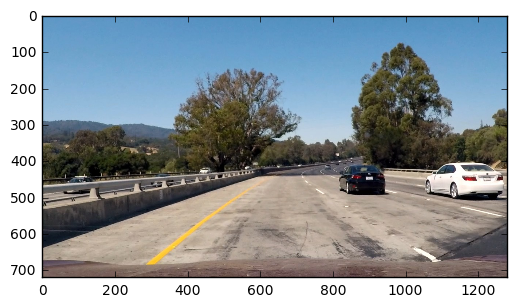

In [69]:
image = mpimg.imread('test_images/test1.jpg')
plt.imshow(image)

In [70]:
# define the minimum window size
x_min =[300, 1280]
y_min =[400, 530]
xy_min = (80, 80)

# define the maxium window size
x_max =[300, 1280]
y_max =[400, 700]
xy_max = (160, 160)

# intermedian windows
n = 4 # the number of total window sizes
x = []
y = []
xy =[]
# chose the intermediate sizes by interpolation.
for i in range(n):
    x_start_stop =[int(x_min[0] + i*(x_max[0]-x_min[0])/(n-1)), 
                   int(x_min[1] + i*(x_max[1]-x_min[1])/(n-1))]
    y_start_stop =[int(y_min[0] + i*(y_max[0]-y_min[0])/(n-1)), 
                   int(y_min[1] + i*(y_max[1]-y_min[1])/(n-1))]
    xy_window    =[int(xy_min[0] + i*(xy_max[0]-xy_min[0])/(n-1)), 
                   int(xy_min[1] + i*(xy_max[1]-xy_min[1])/(n-1))]
    x.append(x_start_stop)
    y.append(y_start_stop)
    xy.append(xy_window)

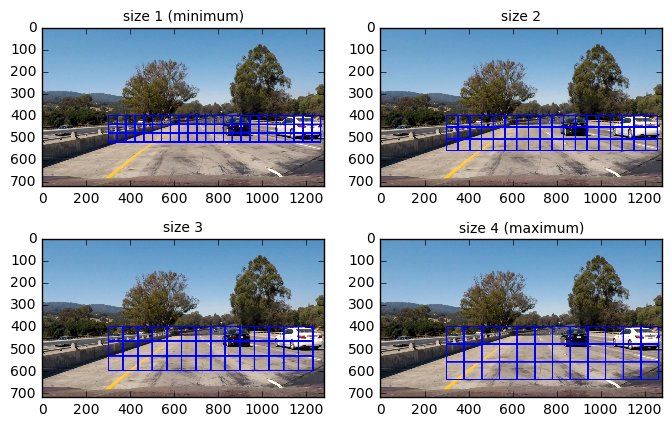

In [85]:
# visualize different window size
windows1 = slide_window(image, x_start_stop= x[0], y_start_stop = y[0], 
                    xy_window= xy[0], xy_overlap=(0.5, 0.5))
windows2 = slide_window(image, x_start_stop= x[1], y_start_stop = y[1], 
                    xy_window= xy[1], xy_overlap=(0.5, 0.5))
windows3 = slide_window(image, x_start_stop= x[2], y_start_stop = y[2], 
                    xy_window= xy[2], xy_overlap=(0.5, 0.5))
windows4 = slide_window(image, x_start_stop= x[3], y_start_stop = y[3], 
                    xy_window= xy[3], xy_overlap=(0.5, 0.5))

window_img1 = draw_boxes(image, windows1, color=(0, 0, 255), thick=6)
window_img2 = draw_boxes(image, windows2, color=(0, 0, 255), thick=6)                    
window_img3 = draw_boxes(image, windows3, color=(0, 0, 255), thick=6)
window_img4 = draw_boxes(image, windows4, color=(0, 0, 255), thick=6)


f, ((ax1, ax2),(ax3,ax4)) = plt.subplots(2,2, figsize=(8,5))
ax1.imshow(window_img1)
ax1.set_title('size 1 (minimum)', fontsize=10)
ax2.imshow(window_img2)
ax2.set_title('size 2', fontsize=10)
ax3.imshow(window_img3)
ax3.set_title('size 3', fontsize=10)
ax4.imshow(window_img4)
ax4.set_title('size 4 (maximum)', fontsize=10)
plt.savefig("output_images/sliding_window.jpg")


Total number of windows: 128


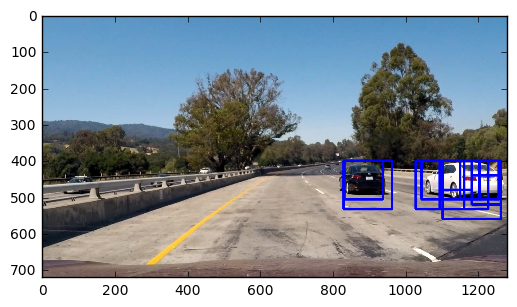

In [119]:
# combine all windows
clf = rf
windows_all = list(windows1 + windows2 + windows3 + windows4)
print('Total number of windows:',len(windows_all))
hot_windows = search_windows(image, windows_all, clf, X_scaler, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=True, 
                        hist_feat=True, hog_feat=True)   

window_img = draw_boxes(image, hot_windows, color=(0, 0, 255), thick=6)                    

plt.imshow(window_img)
plt.savefig("output_images/overlap_window.jpg")


2 cars found


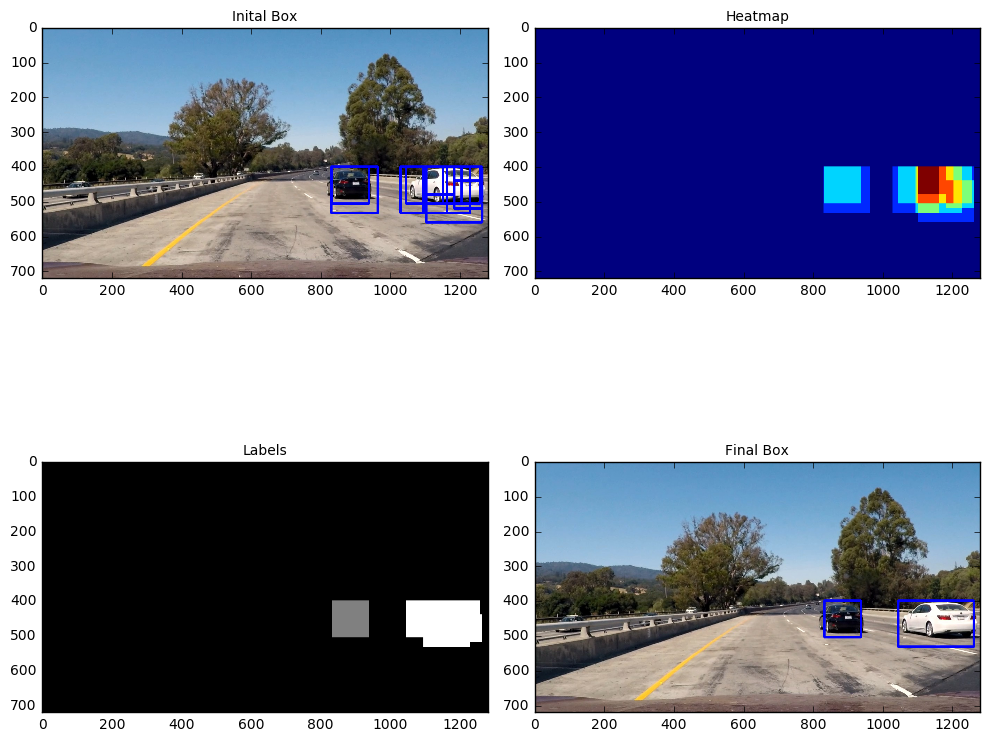

In [128]:
def add_heat(heatmap, bbox_list):
    '''Add "heat" to a map for a list of bounding boxes'''
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    # Return updated heatmap
    return heatmap


def apply_threshold(heatmap, threshold=3):
    '''Zero out heatmap pixels below the threshold and return thresholded heatmap'''
    new_heatmap = np.copy(heatmap)
    new_heatmap[new_heatmap <= threshold] = 0

    return new_heatmap

# define a function to find bounding box of the labels
def find_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    draw_img = np.copy(img)
    bboxes = []
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # append the bounding box to a list
        bboxes.append(bbox)
    # Return the bounding boxes
    return bboxes


# inicalize heat map
heat = np.zeros_like(image[:,:,0]).astype(np.float)
heatmap = add_heat(heat, hot_windows)
labels = label(apply_threshold(heatmap,1.5))
bboxes = find_labeled_bboxes(image, labels)
img_box_final = draw_boxes(image, bboxes, color=(0, 0, 255), thick=6)

print(labels[1], 'cars found')

f, ((ax1, ax2),(ax3,ax4))= plt.subplots(2, 2, figsize=(10,10))
ax1.imshow(window_img)
ax1.set_title('Inital Box', fontsize=10)
ax2.imshow(heatmap)
ax2.set_title('Heatmap', fontsize=10)
ax3.imshow(labels[0], cmap='gray')
ax3.set_title('Labels', fontsize=10)
ax4.imshow(img_box_final)
ax4.set_title('Final Box', fontsize=10)

plt.tight_layout()
plt.show()
plt.savefig("output_images/final_windows.jpg")


### 5.Build Pipeline

In [136]:
def detect_car_basic(img):
    '''
    INPUT:  image from car's front camera
    OUTPUT: image with vehicle detected (denoted by bounding box)
    '''
    hot_windows = search_windows(img, windows_all, clf, X_scaler, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=True, 
                        hist_feat=True, hog_feat=True)   

    #     window_img = draw_boxes(draw_image, hot_windows, color=(0, 0, 255), thick=6) 
#     heat = None
#     heat = np.zeros_like(img[:, :, 0]).astype(np.float)

#     heatmap = add_heat(heat, hot_windows)
#     labels = label(heatmap)
#     bboxes = find_labeled_bboxes(img, labels)
#     img_box_final = draw_boxes(img, bboxes, color=(0, 0, 255), thick=6)


    heat = np.zeros_like(img[:,:,0]).astype(np.float)
    heatmap = add_heat(heat, hot_windows)
    labels = label(heatmap)
    bboxes = find_labeled_bboxes(img, labels)
    img_box_final = draw_boxes(img, bboxes, color=(0, 0, 255), thick=6)

    return img_box_final

In [134]:
heatmap = np.zeros_like(image[:,:,0]).astype(np.float) 
first = True
def detect_car(img):
    '''
    INPUT:  image from car's front camera
    OUTPUT: image with vehicle detected (denoted by bounding box)
    '''
    global heatmap
    global first
    hot_windows = search_windows(img, windows_all, clf, X_scaler, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=True, 
                        hist_feat=True, hog_feat=True)   

    #     window_img = draw_boxes(draw_image, hot_windows, color=(0, 0, 255), thick=6) 
#     heat = None
#     heat = np.zeros_like(img[:, :, 0]).astype(np.float)

#     heatmap = add_heat(heat, hot_windows)
#     labels = label(heatmap)
#     bboxes = find_labeled_bboxes(img, labels)
#     img_box_final = draw_boxes(img, bboxes, color=(0, 0, 255), thick=6)


    heat = np.zeros_like(img[:,:,0]).astype(np.float)
    curr_heatmap = add_heat(heat, hot_windows)
    if first:
        heatmap = curr_heatmap
        first = False
    else:
        heatmap = 0.9*heatmap + 0.1*curr_heatmap
    
    labels = label(apply_threshold(heatmap,1.5))
    bboxes = find_labeled_bboxes(img, labels)
    img_box_final = draw_boxes(img, bboxes, color=(0, 0, 255), thick=6)

    return img_box_final

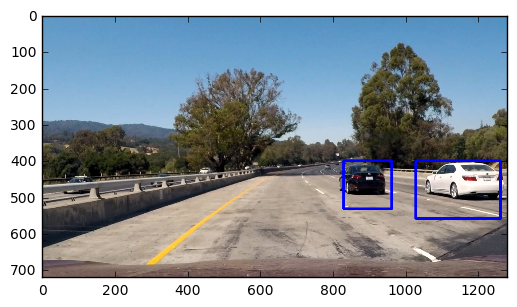

In [131]:
plt.imshow(detect_car(image))

### 6. Test and Output

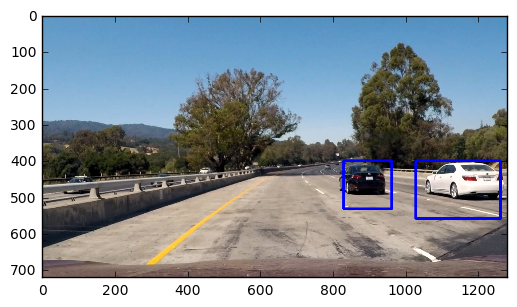

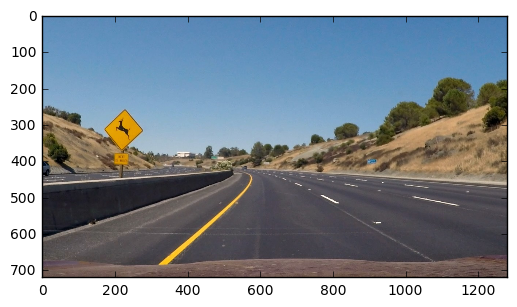

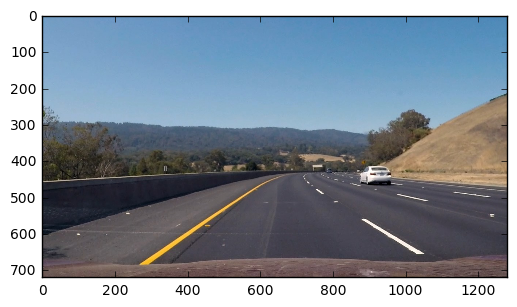

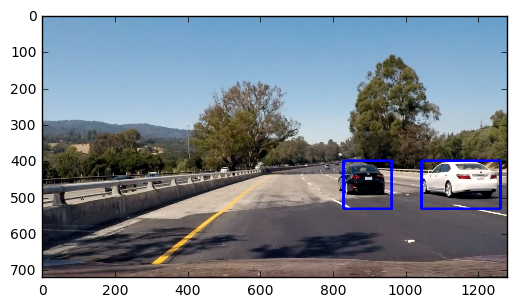

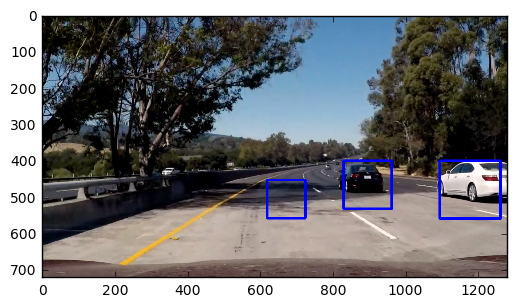

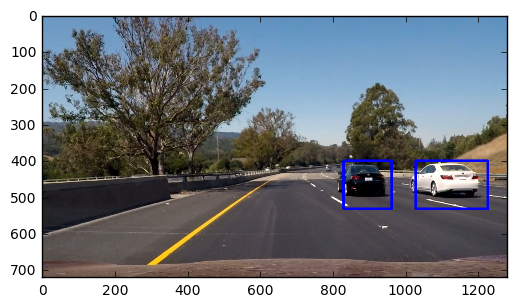

In [137]:
os.listdir("test_images/")

for ima in os.listdir("test_images/"):
    img = mpimg.imread('test_images/'+ima )
    plt.figure()
#     plt.imshow(img)
    plt.imshow(detect_car_basic(img))


In [138]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [ ]:
heatmap = np.zeros_like(image[:,:,0]).astype(np.float) 

# output video directory
video_output = 'project_video_after.mp4'
# input video directory
clip1 = VideoFileClip("project_video.mp4")
# video process pipline
video_clip = clip1.fl_image(detect_car) 
# write processed files
%time video_clip.write_videofile(video_output, audio=False)

[MoviePy] >>>> Building video project_video_after.mp4
[MoviePy] Writing video project_video_after.mp4


  6%|▌         | 72/1261 [00:22<06:09,  3.21it/s]

In [133]:
# show video stream
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(video_output))